In [1]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date
import datetime
import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

### Set up directories

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/03_third_investigation/"

In [3]:
# import glob
# All files ending with .txt
# glob.glob(data_dir + "*.csv")

file_names = [x for x in os.listdir(data_dir) if x.endswith(".csv")]
file_names

['Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv',
 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_L2_2008-01-01_2012-05-05.csv',
 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv']

In [4]:
'Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv'.split("_")

['Grant', '4Fields', 'Landsat7', 'T1', 'L2', '2008-01-01', '2021-07-01.csv']

In [5]:
dataframe_list = []
for curr_f in file_names:
    A = pd.read_csv(data_dir + curr_f)
    if "L2" in curr_f:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + curr_f.split("_")[4] + "_C2"
    elif "Sentinel" in curr_f:
        A["dataset"] = "Sentinel"
    elif "SR" in curr_f:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + curr_f.split("_")[4]

    A = A[A['NDVI'].notna()]
    dataframe_list.append(A)

all_data = pd.concat(dataframe_list)
all_data.reset_index(drop=True, inplace=True)
unique_fields = list(np.sort(all_data.ID.unique()))

all_data = nc.add_human_start_time_by_system_start_time(all_data)

In [6]:
all_data.head(2)

,ID,county,CropTyp,Irrigtn,LstSrvD,doy,EVI,NDVI,system_start_time,image_year,dataset,human_system_start_time
0,106054_WSDA_SF_2017,Grant,"bean, dry",center pivot,2017/06/28,4.0,-0.105867,0.019811,1.199558e+09,2008.0,Landsat7_T1_L2_C2,2008-01-05
1,104563_WSDA_SF_2017,Grant,potato,rill,2017/05/16,20.0,0.451096,-0.038306,1.200940e+09,2008.0,Landsat7_T1_L2_C2,2008-01-21


In [7]:
list(all_data.dataset.unique())

['Landsat7_T1_L2_C2',
 'Sentinel',
 'Landsat7_T1_SR',
 'Landsat5_T1_L2_C2',
 'Landsat8_T1_SR',
 'Landsat5_T1_SR']

### Set the plotting style

In [38]:
size = 20
title_FontSize = 10
legend_FontSize = 8
tick_FontSize = 12
label_FontSize = 14

params = {'legend.fontsize': 'medium',
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 10}

#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)
# pylab.rcParams.update(params)
# plt.rc('text', usetex=True)

### Set the colors

In [9]:
list(np.sort(list(all_data.dataset.unique())))

['Landsat5_T1_L2_C2',
 'Landsat5_T1_SR',
 'Landsat7_T1_L2_C2',
 'Landsat7_T1_SR',
 'Landsat8_T1_SR',
 'Sentinel']

In [10]:
# These are the colors that will be used in the plot
color_dict = {'Sentinel': '#d62728',
              'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat7_T1_SR': 'k', # #8c564b
              'Landsat8_T1_SR': '#2ca02c',
             }

color_dict = {'Sentinel': '#d62728',
              'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat7_T1_SR': 'k', # #8c564b
              'Landsat7_T1_L2_noSnowFilter': '#ff7f0e',
              'Landsat8_T1_SR': '#2ca02c',
              'Landsat5_T1_L2_C2': '#9467bd',
              'Landsat5_T1_SR': '#e377c2'
             }
# 'Landsat7_8day_NDVIComposite': '#1f77b4',

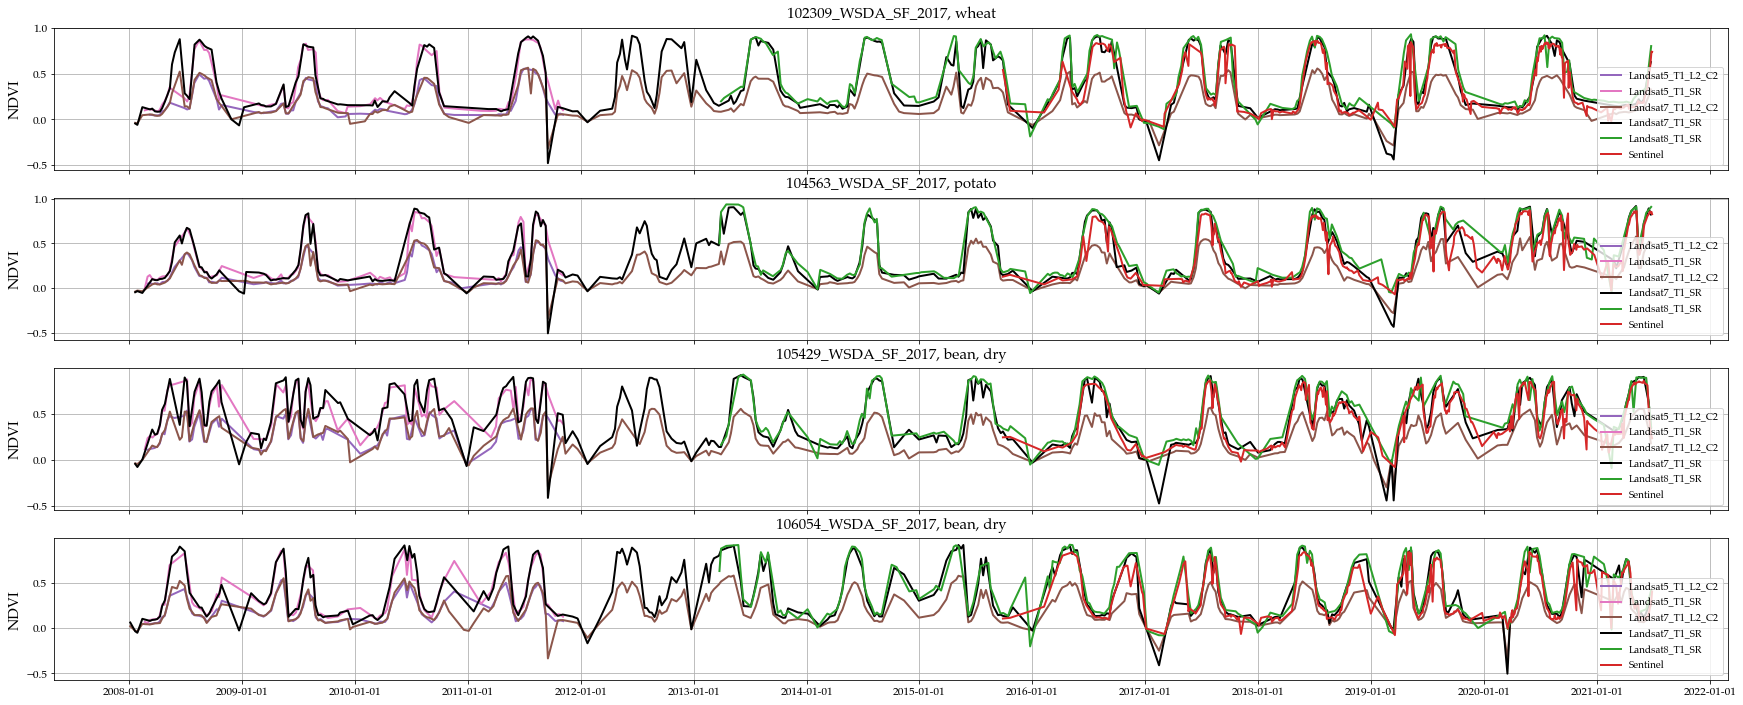

In [11]:

fig, axs = plt.subplots(4, 1, figsize=(30, 12),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

dot_s = 80
#######
#######  subplot 1
#######
field_dt = all_data.loc[all_data.ID == unique_fields[0], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax1.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax1.legend(loc="lower right");

#######
#######  subplot 2
#######
field_dt = all_data.loc[all_data.ID == unique_fields[1], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax2.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)
        

ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax2.legend(loc="lower right");

#######
#######  subplot 3
#######
field_dt = all_data.loc[all_data.ID == unique_fields[2], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax3.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax3.legend(loc="lower right");

#######
#######  subplot 4
#######
field_dt = all_data.loc[all_data.ID == unique_fields[3], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax4.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax4.legend(loc="lower right");
ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# plt.xlim([0, 10000])

file_name = data_dir + "raw_figures/"+ "Grant_4fields_3rd_Investigation_raw.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# Merge Landsat 7 and 8 into one time series

In [12]:
file_names

['Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv',
 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_L2_2008-01-01_2012-05-05.csv',
 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv']

In [13]:
dataframe_list = []

# Read Sentinel
A = pd.read_csv(data_dir + 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv')
A["dataset"] = "Sentinel"
A = A[A['NDVI'].notna()]
dataframe_list.append(A)

# Read Collection 2, Level 2 of Landsat-7
A = pd.read_csv(data_dir + 'Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv')
A["dataset"] = "Landsat7_T1_L2_C2"
A = A[A['NDVI'].notna()]
dataframe_list.append(A)


# Read Landsat 5, 7, and 8 and merge them together

L5 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat5_T1_SR_2008-01-01_2013-06-05.csv')
L5["dataset"] = "Landsat578_T1_SR"
L5 = L5[L5['NDVI'].notna()]

L7 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv')
L7["dataset"] = "Landsat578_T1_SR"
L7 = L7[L7['NDVI'].notna()]

L8 = pd.read_csv(data_dir + 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv')
L8["dataset"] = "Landsat578_T1_SR"
L8 = L8[L8['NDVI'].notna()]

L78 = pd.concat([L5, L7, L8])
dataframe_list.append(L78)

In [14]:
all_data = pd.concat(dataframe_list)
all_data.reset_index(drop=True, inplace=True)
all_data = nc.add_human_start_time_by_system_start_time(all_data)

In [15]:
# These are the colors that will be used in the plot
color_dict = {'Landsat7_T1_L2_C2': '#8c564b', 
              'Landsat578_T1_SR': 'k',
              'Sentinel': '#d62728'
             }

In [16]:
all_data.dataset.unique()

array(['Sentinel', 'Landsat7_T1_L2_C2', 'Landsat578_T1_SR'], dtype=object)

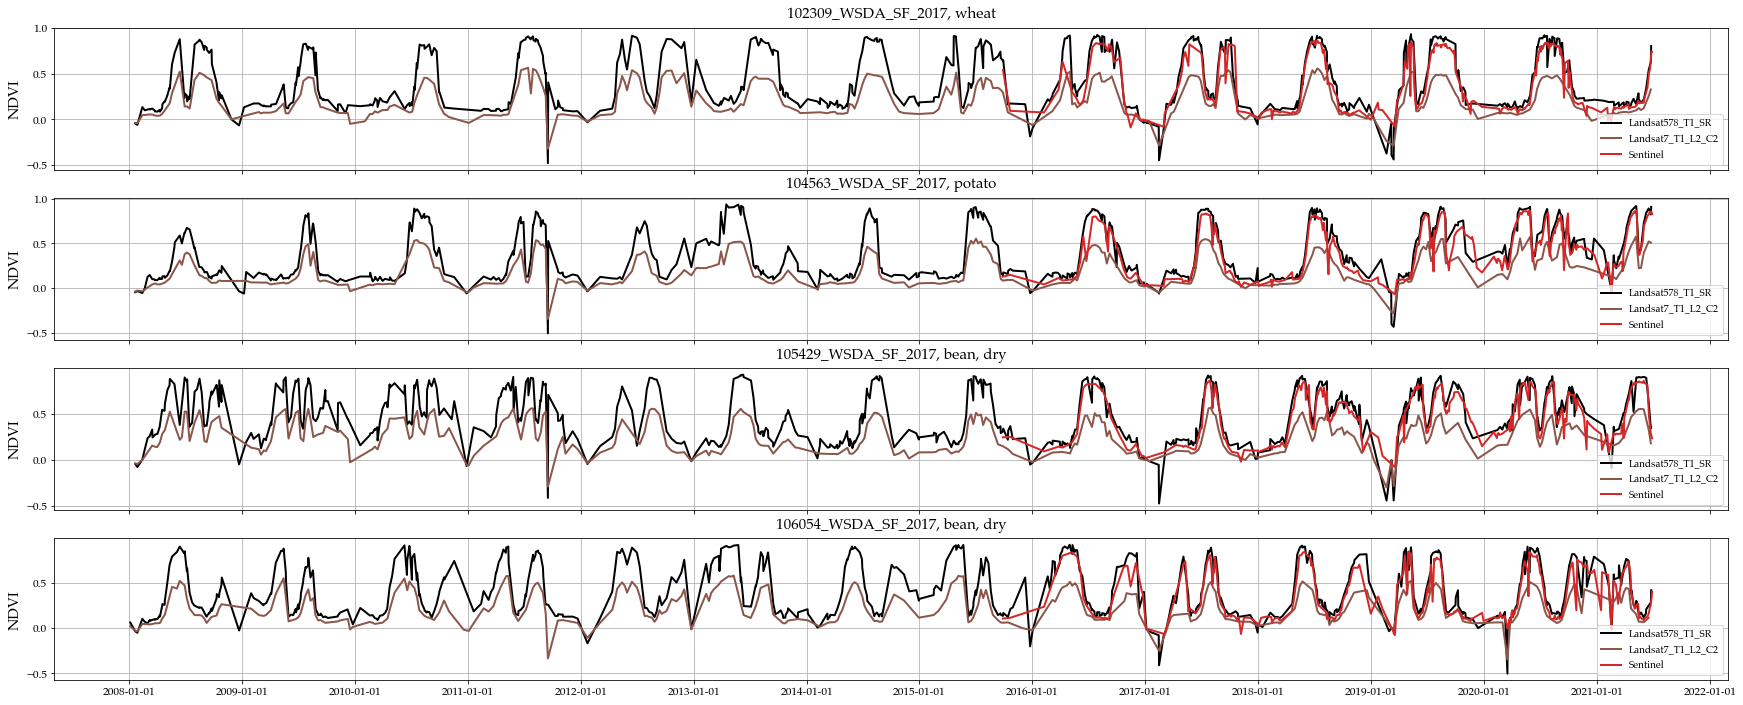

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(30, 12),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

dot_s = 80
#######
#######  subplot 1
#######
field_dt = all_data.loc[all_data.ID == unique_fields[0], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax1.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax1.legend(loc="lower right");

#######
#######  subplot 2
#######
field_dt = all_data.loc[all_data.ID == unique_fields[1], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax2.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)
        

ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax2.legend(loc="lower right");

#######
#######  subplot 3
#######
field_dt = all_data.loc[all_data.ID == unique_fields[2], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax3.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax3.legend(loc="lower right");

#######
#######  subplot 4
#######
field_dt = all_data.loc[all_data.ID == unique_fields[3], ].copy()
for curr_dataset in np.sort(field_dt.dataset.unique()):
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax4.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax4.legend(loc="lower right");
ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# plt.xlim([0, 10000])

file_name = data_dir + "raw_figures/"+ "Grant_4fields_3rdInvest_578Merged.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)